In [ ]:
 У нас имеется база данных в кикхаусе, куда ежедневно записываются данные по пользователям ленты новостей.
Лента новостей представляет из себя посты с возможностью их просматривать, лайкать, и также отправлять сообщения
друг другу. Действия по ленте новостей это like и view, действия по месссенджеру заполняются отдельной схемой в БД
и включают просто сообщения, кому и когда. В целом, лента и мессенджер составляют некое приложение, которое мы 
хотим развивать, наполняя новыми пользователями и поддерживая их активность.
 Мы тестируем метрику CTR, поскольку она учитывает "базовую" активность (просмотры). Это делает её более надёжной 
для оценки изменений в заинтересованности, чем абсолютные значения лайков.

In [1]:
# Импортируем все необходимое
from scipy import stats
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm, ttest_ind
# Создаём генератор псевдослучайных чисел
rng = np.random.default_rng() 

In [2]:
# Стандартная формула расчета размера выборки пригодится нам для сравненеия
# округляется вверх (np.ceil) до целого числа.
# Обратная функция нормального распределения, это функция, которая для вероятности p возвращает значение Z
# p(Z<=значение) = p.
# -1 это математическое обозначение обратной функции (не степень)
# norm.ppf(p) — это функция, возвращающая квантиль(Z значение) для вероятности p 
def compute_sample_size_abs(epsilon, std1, std2, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1) # Z-оценка для двустороннего теста
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)  #  Z-оценка для мощности
    z_scores_sum_squared = (t_alpha + t_beta) ** 2 
    sample_size = int(                                   # сумма дисперсий  
        np.ceil(z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2))  #детектируемый эффект
    )
    return sample_size

In [2]:
#  Соединяемся с кликхаус
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}
# Получим запрос который для каждого количества просмотров покажет - сколько пользователей имеют
# именно такое количество
q = """
SELECT views, count() as users
FROM(SELECT
    user_id,
    sum(action = 'view') as views
    FROM {db}.feed_actions 
    WHERE toDate(time) >= toDate('2024-12-27') and toDate(time) <= toDate('2025-01-02')
    GROUP BY user_id)
group by views
order by views
"""
# Запрос исходной таблицы из БД для понимания структуры таблицы
q_table = """
SELECT *
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) <= toDate('2025-01-04')"""

In [3]:
# Наша исходная таблица со всеми данными по каждому пользователю и группой exp_group
df_table = ph.read_clickhouse(q_table, connection=connection)
df_table.head(5)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,123767,2040,view,2025-01-04 20:06:53,1,21,Russia,Samara,Android,organic,1
1,129655,2116,view,2025-01-04 20:06:53,0,26,Russia,Saint Petersburg,iOS,organic,4
2,131026,2095,view,2025-01-04 20:06:53,1,22,Russia,Moscow,Android,organic,4
3,28786,2167,view,2025-01-04 20:06:54,1,16,Russia,Moscow,iOS,ads,2
4,131026,2048,view,2025-01-04 20:06:54,1,22,Russia,Moscow,Android,organic,4


In [4]:
views_distribution = ph.read_clickhouse(q, connection=connection)
# Распределение просмотров по количеству пользователей
views_distribution.head(4)

,views,users
0,1,4
1,2,1
2,3,4
3,4,5


In [4]:
# Нормируем распределение поделив каждое количество (пользователей) на общую сумму
# получив вероятность появления такого события для каждого
views_distribution.users.sum()
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()
views_distribution.head(5)

,views,users,p
0,1,4,0.000095
1,2,1,0.000024
2,3,4,0.000095
3,4,5,0.000119
4,5,18,0.000429


In [5]:
# Дискретное распределение описывает вероятности 'p' исходов для дискретной (1,2,3..)  величины 'views'
# views_distr - это будет объект дискретного распределения из которого можно генерировать выборки с помощью rvs
# Нормировка гарантирует, что сумма всех вероятностей равна 1. 
# Это необходимо чтоб просмотры отбирались НЕ равновероятно, а в соответствии с их 'p' - что сохранить
# репрезентативность выборки
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

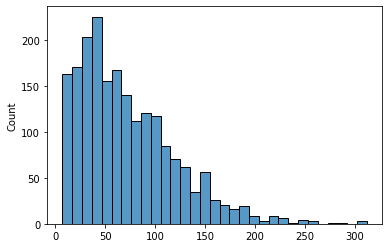

In [6]:
# Посмотрим на наше дискретное распределение просмотров
sns.histplot(views_distr.rvs(size=2000))
plt.show()

In [7]:
# Среднее, медиана и стандартное отклонение для выборки просмотров размера 2000
mean = views_distr.mean() 
med = views_distr.median()
std_view = views_distr.std()
print(f'mean = {mean}, med = {med}, std = {std_view}')

mean = 70.30916494035289, med = 60.0, std = 46.795649294309676


In [ ]:
CRT достаем по дням (Потому что CTR зависит не только от желания пользователя ставить лайки на посты.
Он ещё зависит от качества самих постов - в некоторые дни посты оказываются лучше обычного, и пользователи
начинают их прилично лайкать. А в другие дни посты плохие, и пользователи лайкают их меньше - даже если в 
среднем их тенденция ставить лайки высокая) подсказка

In [7]:
# Запрос в кликхаус CTR на пользователя по дням - в подзапросе
# и после достаем распределение CTR по количеству пользователей
q = """
SELECT floor(ctr, 2) as ctr, count() as users
FROM(SELECT toDate(time) as dt,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= toDate('2024-12-27') and toDate(time) <= toDate('2025-01-02')
    GROUP BY user_id, dt
    HAVING sum(action = 'view') != 0 and sum(action = 'like') != 0)
group by ctr
order by ctr
"""


ctr_distribution = ph.read_clickhouse(q, connection=connection)
ctr_distribution.head(3)                     

,ctr,users
0,0.02,48
1,0.03,142
2,0.04,312


In [8]:
# Нормируем CTR
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.sort_values(by = 'p', ascending = False)

# Создаём распределение, где каждому индексу соответствует своя вероятность
# поскольку CTR не целые числа, работаем через индексы. Метод rv_discrete работает с целым значением
probabilities = ctr_distribution['p']
values = ctr_distribution['ctr']
distrib = stats.rv_discrete(values=(range(len(probabilities)), probabilities)) # Распределение индексов 'ctr'

# Функция подставит соответствующие индексам CTR 
# Далее мы будем генерить выборки для просмотров и CTR
# т.к тут работаем с индексами сделаем функцию которая сразу будет нам создавать
# необходимый массив
def get_ctrs(x, y, distrib, values): 
    idx = distrib.rvs(size=x*y)         # Генерирует массив индексов длины x*y согласно распределению distrib
    result = values[idx]                # Берем занчения CTR
    return np.array(result).reshape(x,y)


In [ ]:
# Через numpy можно применять в том числе и на дробных значениях
# rng.choice(значения_метрики, size=(количество_симуляций, размер_выборки), 
#             replace=True, p=относительные_частоты)

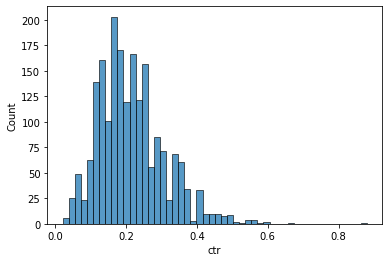

In [9]:
# Распределение сэмплированных CTR
sns.histplot(values[distrib.rvs(size=2000)])
plt.show()

In [10]:
# Сделаем запрос чтоб получить стандартное отклонение ctr для наших выборок
q = """
select 
   stddevPop(ctr) as ctr_std
from (select toDate(time) as dt, 
      exp_group,
      user_id,
      sum(action = 'like')/sum(action = 'view') as ctr
      from {db}.feed_actions
      where dt between '2024-12-27' and '2025-01-02'
      and exp_group in (0,1,2,3,4)
      group by dt, exp_group, user_id)
"""

std_ctr = ph.read_clickhouse(q, connection=connection).values[0][0]
std_ctr

0.0984458178473161

In [12]:
# Посмотрим какой размер выборки дает нам формула примерно, чтоб видеть от чего оттолкнуться
# Размер эффекта который мы хотим детектировать возьмем 0.01
compute_sample_size_abs(0.01, std_ctr, std_ctr)

1522

In [ ]:
Делаем выборки для просмотров и CTR (один из которых меняем на величину эффекта)
Распределение лайков получаем как биномиальное от просмотров и CTR
мы хотим заметить изменения в 0.01 а среднее CTR=0.21 значит умножить исходное надо на 0,01/0,21 = 1.05
 .astype("int32") может округлять дробные значения до 0 - np.maximum заменит на 1

In [13]:
group_A_views = views_distr.rvs(size = (2000, 1600)) 
group_A_views = np.maximum(group_A_views, 1).astype("int32")   # Замена  0 на 1. сравнивает каждое значение массива 
group_B_views = views_distr.rvs(size = (2000, 1600))           # с 1 и берет большее
group_B_views = np.maximum(group_B_views, 1).astype("int32")   # Замена  0 на 1
# Генерация CTR с ограничением до 1.0
group_A_ctr = np.minimum(get_ctrs(2000, 1600, distrib, values) * 1.05, 1.0) '''Вводим синтетический эффект'''
group_B_ctr = get_ctrs(2000, 1600, distrib, values) 

# Генерация лайков
clicks_A = stats.binom.rvs(n=group_A_views, p=group_A_ctr)
clicks_B = stats.binom.rvs(n=group_B_views, p=group_B_ctr)

In [14]:
# zip(a, b) создает пары вида (a[i], b[i]) - 2000 кортежей по 1600 пар значений в каждом
# x[0], x[1] - это будет соответственно a[i] b[i] массивы выборок
# Получим массив из 2000 pvalue
def t_test(a, b):
    """
    Считает p-value для t-теста с двусторонней альтернативой 
    :param a: np.array вида (n_experiments, n_users), значения метрик в контрольных группах
    :param b: np.array вида (n_experiments, n_users), значения метрик в тестовых группах
    :return: np.array вида (n_experiments), посчитанные p-value t-теста для всего списка экспериментов
    """
    result = list(map(lambda x: stats.ttest_ind(x[0], x[1], equal_var=False).pvalue, zip(a, b)))
    return np.array(result)

In [15]:
# По умолчанию (axis=0) функция сравнивает столбцы массивов
# Смотрим процент успешных срабатываний (должен быть > 80%)
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.741

In [ ]:
Для точного расчета обычная формула (1522 пользователя) не добирает необходимое количество пользователей 
для заданной мощности, поскольку симуляция на размере выборки 1600 дает только 74% мощности

In [33]:
# Выразим из формулы размера выборки - мощность power 
# И напишем фукнцию котороя будет считать мощность от размера выборки т.е. просто подсчет наоборот
def compute_power(epsilon, std1, std2, N, alpha=0.05):
    z_alpha = norm.ppf(1 - alpha/2)  # Квантиль для двустороннего теста
    
    # Вычисляем Z-скор для мощности
    z_power = (np.sqrt(N) * epsilon) / np.sqrt(std1**2 + std2**2) - z_alpha
    
    # Преобразуем Z-скор в вероятность (мощность)
    power = norm.cdf(z_power)    
    return power

100%|██████████| 12/12 [00:33<00:00,  2.80s/it]


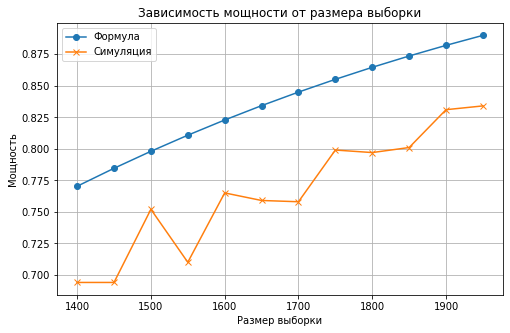

In [40]:
# Сделаем цикл в который будем передовать последовательно размер выборки и фиксировать
# мощность от формулы и от генерации Монте-Карло, чтоб построить график
from tqdm import tqdm # Для наблюдения за процессом работы
alpha = 0.05
epsilon = 0.01  # Размер эффекта (пример)
std1 = 0.098      # Стандартное отклонение группы A (пример)
std2 = 0.098      # Стандартное отклонение группы B (пример)
sample_size = np.arange(1400, 2000, 50) # Начнем с размера выборки 1400 и до 2000 шаг 50
formula = []
simulation = []
for N in tqdm(sample_size):
    formula_power = compute_power(epsilon, std1, std2, N, alpha=0.05)
    formula.append(formula_power)
    group_A_views = views_distr.rvs(size = (1000, N)) 
    group_A_views = np.maximum(group_A_views, 1).astype("int32")   # Замена  0 на 1
    group_B_views = views_distr.rvs(size = (1000, N))
    group_B_views = np.maximum(group_B_views, 1).astype("int32")   # Замена  0 на 1
    # Генерация CTR с ограничением до 1.0
    # get_ctrs генерирует массив индексов длины x*y согласно распределению distrib
    group_A_ctr = np.minimum(get_ctrs(1000, N, distrib, values) * 1.05, 1.0)
    group_B_ctr = get_ctrs(1000, N, distrib, values)
    # Генерация лайков
    clicks_A = stats.binom.rvs(n=group_A_views, p=group_A_ctr)
    clicks_B = stats.binom.rvs(n=group_B_views, p=group_B_ctr)
    mk_power = np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/1000
    simulation.append(mk_power)
    
plt.figure(figsize=(5, 3))
plt.plot(sample_size, formula, label='Формула', marker='o')
plt.plot(sample_size, simulation, label='Симуляция', marker='x')
plt.xlabel('Размер выборки')
plt.ylabel('Мощность')
plt.title('Зависимость мощности от размера выборки')
plt.legend()
plt.grid(True)
plt.show()    

In [ ]:
Видим что заданая мощность достигается быстрее на расчетах из обычной формулы, а для Монте-Карло гараздо позднее.
Обращаем внимание что размер выборки посчитан на данных, за определенное время (неделя)
значит и сам тест должен включать данные за неделю, чтоб заметить нужный эффект с нужной мощностью.
Кроме того стоит заметить что мы вводим синтетический эффект равномерно на кождый CTR! Но в реальности
не все метрики будут изменяться вот так равномерно, поэтому возможно нужно будет подумать что и как измерять
для расчета размера выборки.